## Part 3

Now lets move to neural networks.

Min: [19:13](https://youtu.be/VMj-3S1tku0)

**Note**: the `__init__` method is equivalent to a constructor in `C++`

**Note**: In Python, `__repr__` is a special method used to represent a class’s objects as a string. `__repr__` is called by the repr() built-in function. You can define your own string representation of your class objects using the `__repr__` method.

**Note**: The `__add__()` method in Python specifies what happens when you call `+` on two objects. When you call `obj1 + obj2`, you are essentially calling `obj1.__add__(obj2)`.

**Note**: **Single underscore** (i.e., `_children`) in a class, names with a leading underscore indicate to other programmers that the attribute or method is intended to be be used inside that class. However, privacy is not enforced in any way. Using leading underscores for functions in a module indicates it should not be imported from somewhere else.



In [1]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        # this variable maintains the derivative of it with respect to that value
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, input):
        output = Value(self.data + input.data, (self, input), '+')
        return output
    
    def __mul__(self, input):
        output = Value(self.data * input.data, (self, input), '*')
        return output    

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad,), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

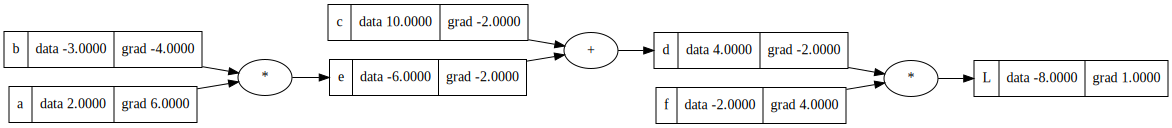

In [39]:
draw_dot(L)

## Now in this step we are going to perform back propagation manually.

So what is the dirivative of L with respect to L **dL/dL**

In [24]:
# We write this function to not pullute the global scope
def foo():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h
    
    print((L2 - L1)/h)

# Notice that the derivate is 1
foo()

0.9999999999976694


In [25]:
L.grad = 1.0 # Make sure to rerun the draw_dow(L) method again above so it updates.

Now lets run the derivatives of `dL/dd` and `dL/df`

We know that `L = d * f`

And we would like to know what `dL/dd = ?` (the value is `f` but lets prove it)

The definition of a derivative is:

`(f(x + h) - f(x)) / h` as a limit of h to 0

So

`dL/dd = f'(d, f) = [(d + h)*f - (d * f)] / h = [d*f + h*f - d*f]/h = hf / h = f`

In [27]:
d.grad = -2.0
f.grad = 4

In [33]:
# We write this function to not pullute the global scope
# We do this for our derivative proof
# Note: what we are doing here is numerical gradiant
def foo2():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

# Notice that the derivate is 1
foo2()

-1.9999999999953388


Now we want `dL/dc` and `dL/de`

So what is `dd/dc`? We know from calculus that the answer is `1` so lets proove it.

We know that `d = c + e`

`dd/dc = [(c + h) + e - (c + e)] / h`

`=>      (h / h) = 1`


We use the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) since at the end we are looking at how changes affect `L`. 

Therefore, `dL/dc = dL/dd * dd/dc` => `-2 * 1`.


In [35]:
c.grad = -2.0
e.grad = -2.0

So now we want: `dL / da`

=> `dL/da = dL/de * de/da`

`e = a * b`

`de/da = [(a + h)*b - (a * b)] / h = [a*b + h*b - a*b] / h = b`

Therefore:

`de/da = b = -3`
`de/db = a = 2`

So 

`dL/da = -2.0 * -3.0 = 6.0`

`dL/db = -2.0 * 2 = -4.0`

In [38]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0